<a href="https://colab.research.google.com/github/NigamaVeena/Inscriptions-translation/blob/main/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-gpu==1.15.0
!pip install tensorflow_hub

     |████████████████████████████████| 411.5MB 41kB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 512kB 51.1MB/s 
     |████████████████████████████████| 3.8MB 50.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=91e7231d65783099e42b9b5e4593686ad7021982f5c76091649dffd514711fa4
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorflow-estimator<2.5.0,>=2.4.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

     |████████████████████████████████| 411.5MB 42kB/s 
     |████████████████████████████████| 3.8MB 51.7MB/s 
     |████████████████████████████████| 512kB 50.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=bf2e887135f6bf0c06e74f20b20426dac03a3d787ee1e6d4c51a0c2292037c28
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installa

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [ ]:
data_root='/content/drive/MyDrive/characters';
print(data_root);


/content/drive/MyDrive/characters


In [ ]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [ ]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  1.15.0
Hub version:  0.10.0
Eager mode:  False
GPU is available


In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

/content/drive/MyDrive/characters
Found 25 images belonging to 10 classes.


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 110 images belonging to 10 classes.


In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 10)


In [ ]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Ic_A' 'Ic_Aa' 'Ic_E' 'Ic_Ee' 'Ic_Ru' 'Ic_Ruu' 'Ic_Vu' 'Ic_Vuu' 'Ic_Ye'
 'Ic_Yee']


In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=25,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/25
4/4 [==============================] - 30s 7s/step - loss: 2.8707 - acc: 0.1932 - val_loss: 2.5098 - val_acc: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 0s 84ms/step - loss: 2.3316 - acc: 0.1717 - val_loss: 2.1845 - val_acc: 0.1200
Epoch 3/25
4/4 [==============================] - 0s 114ms/step - loss: 1.9616 - acc: 0.2717 - val_loss: 1.9051 - val_acc: 0.2000
Epoch 4/25
4/4 [==============================] - 1s 128ms/step - loss: 1.6129 - acc: 0.4228 - val_loss: 1.6441 - val_acc: 0.3600
Epoch 5/25
4/4 [==============================] - 0s 120ms/step - loss: 1.3839 - acc: 0.5003 - val_loss: 1.4597 - val_acc: 0.3600
Epoch 6/25
4/4 [==============================] - 1s 129ms/step - loss: 1.1589 - acc: 0.5758 - val_loss: 1.2987 - val_acc: 0.5600
Epoch 7/25
4/4 [==============================] - 0s 116ms/step - loss: 1.0644 - acc: 0.6092 - val_loss: 1.1621 - val_acc: 0.6800
Epoch 8/25
4/4 [==============================] - 1s 128ms/step - loss: 0.8553 - acc: 0.6

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

1/1 [==============================] - 0s 112ms/step - loss: 0.6288 - acc: 0.8400


In [ ]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.63
Final accuracy: 84.00%


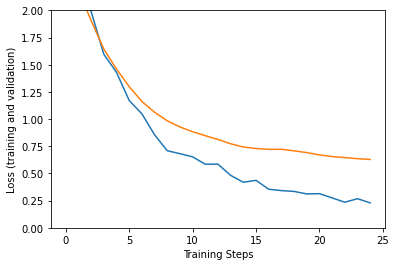

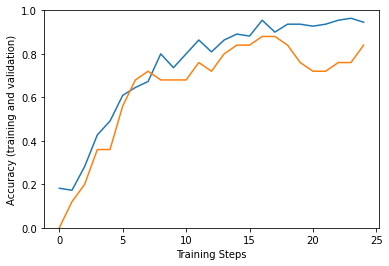

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (25, 224, 224, 3)


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (25, 10)


In [ ]:
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Ic_A,Ic_Aa,Ic_E,Ic_Ee,Ic_Ru,Ic_Ruu,Ic_Vu,Ic_Vuu,Ic_Ye,Ic_Yee
0,0.10431085,0.50161165,0.19427595,0.03790023,0.01264780,0.02450358,0.03595677,0.00269931,0.04730499,0.03878885
1,0.00055258,0.00162230,0.00084812,0.00761581,0.61262286,0.12977314,0.00666781,0.19515288,0.00878291,0.03636150
2,0.00158009,0.00836231,0.00175880,0.00284822,0.68803114,0.10790072,0.00085019,0.02790834,0.10769545,0.05306474
3,0.00017749,0.00487095,0.01042664,0.00194046,0.37122455,0.10651713,0.09372710,0.23937768,0.12390943,0.04782854
4,0.79868287,0.17166880,0.00738426,0.00331336,0.00130571,0.00194725,0.00978114,0.00115794,0.00345352,0.00130507


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

IndexError: ignored

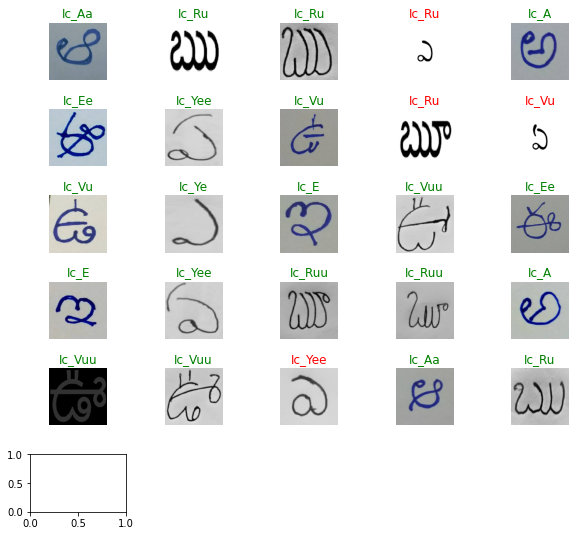

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [2]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix

In [ ]:
path1=r'/content/10.png'
path2=r'/content/4.png'

In [ ]:
import cv2

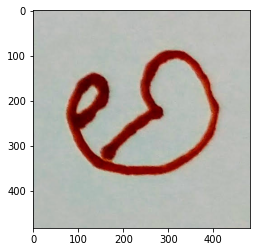

In [ ]:
img1=cv2.imread(path1)
plt.imshow(img1)

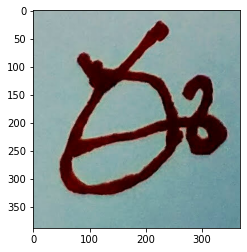

In [ ]:
img2=cv2.imread(path2)
plt.imshow(img2)

In [ ]:
img.shape

(483, 482, 3)

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:

from tensorflow.keras.preprocessing import image

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0  # normalize to [0,1] range

    return image


# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)

    return preprocess_image(image)

In [ ]:
IMAGE_SIZE=224

In [ ]:
preprocessed_imgage = load_and_preprocess_image(path1)
preprocessed_imgage = tf.reshape(
        preprocessed_imgage, (1, IMAGE_SIZE, IMAGE_SIZE, 3)
    )

In [ ]:
prob = model.predict(preprocessed_imgage,steps=1)


In [ ]:
pred_ids = np.argmax(prob, axis=-1)
pred_labels = dataset_labels[pred_ids]

In [ ]:
pred_ids

array([1])

In [ ]:
pred_labels[0]

'Ic_Aa'

In [ ]:
le=len(pred_labels[0])
pred_labels[0][3:le]

'Aa'

In [ ]:
preprocessed_imgage1 = load_and_preprocess_image(path2)
preprocessed_imgage1 = tf.reshape(
        preprocessed_imgage1, (1, IMAGE_SIZE, IMAGE_SIZE, 3)
    )

In [ ]:
prob1 = model.predict(preprocessed_imgage1,steps=1)


In [ ]:
pred_ids1 = np.argmax(prob1, axis=-1)
pred_labels1 = dataset_labels[pred_ids1]

In [ ]:
le1=len(pred_labels1[0])
pred_labels1[0][3:le1]

'Ee'

In [ ]:
pip install cropyble

  Created wheel for cropyble: filename=cropyble-1.2.0-cp36-none-any.whl size=4326 sha256=7c716d612689cdad6efe009a90afd4256bea8c0abc0bf6ed244a8bca52986e10
  Stored in directory: /root/.cache/pip/wheels/6c/10/d0/9a26fd1c098e9e91df450b02f7c98fd1702b52b024063c3a02
  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13943 sha256=6ec10e29dbf0f5a7fa65779904ae7bd698777b74b04cf376d725ec5051a214bd
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built cropyble pytesseract


In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,602 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import pytesseract

In [ ]:
from cropyble import Cropyble
pat=r'/content/gunin1.PNG'
im=cv2.imread(pat)
my_img = Cropyble(pat)
my_img.crop('SASTRA', 'output.jpg')

IsADirectoryError: ignored